In [1]:
# ----------------------
# Import libraries
# ----------------------

import os
import glob
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [2]:

print("PyTorch:", torch.__version__)
print("CUDA usada pelo PyTorch:", torch.version.cuda)
print("CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU detectada:", torch.cuda.get_device_name(0))
    print("Exemplo de tensor no dispositivo:", torch.tensor([1.0, 2.0]).to("cuda"))


PyTorch: 2.7.1+cu128
CUDA usada pelo PyTorch: 12.8
CUDA disponível: True
GPU detectada: NVIDIA GeForce RTX 4060
Exemplo de tensor no dispositivo: tensor([1., 2.], device='cuda:0')


In [5]:
# --------------------------------
# Dataset download from Kaggle
# --------------------------------

def download_kagglehub_dataset():
    """
    Faz o download do dataset via KaggleHub e move automaticamente a pasta Dataset_hdf
    (ou a primeira pasta encontrada) para o diretório atual.
    """
    dataset_name = "lucasalexandre1997/fault-line-time-series-hdf"
    print("Baixando dataset do KaggleHub...")

    cache_path = kagglehub.dataset_download(dataset_name)
    print(f"Download concluído.")
    print("Importando os arquivos...")

    # Procurar a pasta Dataset_hdf (ou similar)
    found_path = None
    for root, dirs, files in os.walk(cache_path):
        for d in dirs:
            if "dataset" in d.lower() or "hdf" in d.lower():
                found_path = os.path.join(root, d)
                break
        if found_path:
            break

    if found_path is None:
        print("Nenhuma pasta chamada 'Dataset_hdf' encontrada, usando raiz do download.")
        found_path = cache_path

    dest_dir = os.path.join(os.getcwd(), "Dataset_hdf")

    # Remove versão antiga, se existir
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)

    # Copia a pasta detectada para o diretório atual
    shutil.copytree(found_path, dest_dir)
    print(f"Dataset copiado para o diretório do script")

download_kagglehub_dataset()
data_dir = 'Dataset_hdf' 
file_pattern = "*.h5"

Baixando dataset do KaggleHub...


100%|██████████| 10.8G/10.8G [17:34<00:00, 11.0MB/s]  

Extracting files...


Download concluído.
Importando os arquivos...
Dataset copiado para o diretório do script


In [7]:
# -----------------------
# User config
# -----------------------
fault_time = 1.5                 # seconds
pre_window = 0.2                 # seconds before fault
post_window = 0.5                # seconds after fault
dt = 50e-6                       # 50 microseconds = sampling step
sample_rate = 1.0 / dt
window_len = int(round((pre_window + post_window) * sample_rate))
channels = ['Ea', 'Eb', 'Ec', 'Ia', 'Ib', 'Ic']       # electrical signals measured E - voltage/ I - Current
seed = 42
batch_size = 8                   # reduce if GPU OOM, increase if plenty mem
num_epochs = 100
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")
random_state = seed

Usando dispositivo: cuda


In [9]:
# ------------------------------------
# Class definitions
# ------------------------------------

# classes order
class_list = ['NoFault', 'LG', 'LL', 'LLG', 'LLLG']

def infer_label_from_filename(fname):
    # check longer tokens first
    base = os.path.basename(fname)
    if 'NF' in base:
        return 'NoFault'
    # check explicit patterns in order
    if 'LLLG' in base:
        return 'LLLG'
    if 'LLG' in base and 'LLLG' not in base:
        return 'LLG'
    if 'LL' in base and 'LLG' not in base and 'LLG' not in base:
        # ensure not matching 'llg' portion
        # but this will match both 'll' in 'llg' unless excluded above
        return 'LL'
    if 'LG' in base and 'LL' not in base:  # avoid 'll' confusion
        return 'LG'
    return None

In [11]:
# =============================
# Load and preprocess files
# =============================
def load_all_files(data_dir, file_pattern="*.h5"):
    files = sorted(glob.glob(os.path.join(data_dir, file_pattern)))
    X_list = []
    y_list = []
    filenames_used = []

    center_idx = int(round(fault_time / dt))
    half_len = window_len // 2
    start_idx = center_idx - half_len
    end_idx = start_idx + window_len  # exclusive

    print(f"Window len {window_len} samples. center_idx {center_idx}, start {start_idx}, end {end_idx}")

    for f in tqdm(files, desc="Reading files"):
        try:
            df = pd.read_hdf(f)
        except Exception as e:
            print(f"[WARN] Cannot read {f}: {e}")
            continue

        # check columns
        if not all(c in df.columns for c in ['Time'] + channels):
            print(f"[WARN] File {f} missing required columns. Skipping.")
            continue

        # ensure enough length
        n_samples = len(df)
        if start_idx < 0 or end_idx > n_samples:
            print(f"[WARN] File {f} too short ({n_samples} samples). Skipping.")
            continue

        # cut window
        window_df = df.iloc[start_idx:end_idx]
        # arrange in shape (channels, length)
        arr = np.stack([window_df[ch].to_numpy() for ch in channels], axis=0).astype(np.float32)
        # normalize per-sample per-channel (z-score)
        means = arr.mean(axis=1, keepdims=True)
        stds = arr.std(axis=1, keepdims=True)
        stds[stds == 0] = 1.0
        arr = (arr - means) / stds

        label = infer_label_from_filename(f)
        if label is None:
            print(f"[WARN] Could not infer label for {f}. Skipping.")
            continue
        if label not in class_list:
            print(f"[WARN] Label '{label}' not in class list. Skipping.")
            continue

        X_list.append(arr)   # shape (6, window_len)
        y_list.append(class_list.index(label))
        filenames_used.append(os.path.basename(f))

    if len(X_list) == 0:
        raise RuntimeError("No files loaded. Check directory and labels.")

    X = np.stack(X_list, axis=0)  # (N, channels, L)
    y = np.array(y_list, dtype=np.int64)
    print(f"Loaded {len(X)} samples. Class distribution:")
    unique, counts = np.unique(y, return_counts=True)
    for u,c in zip(unique, counts):
        print(f"  {class_list[u]}: {c}")
    return X, y, filenames_used

In [13]:
# =======================
# PyTorch Dataset
# =======================
class SeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
# ========================
# Model: 1D CNN
# ========================
class CNN1D(nn.Module):
    def __init__(self, in_channels=6, num_classes=5):
        super().__init__()
        # keep model small to handle long sequences
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),  # /2

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),  # /4

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),  # /8
        )
        # compute flattened size dynamically for given window
        dummy = torch.zeros(1, in_channels, window_len)
        feat_len = self.encoder(dummy).shape[2]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * feat_len, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

In [17]:
# =====================================
# Training / evaluation utilities
# =====================================
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return running_loss / total, correct / total

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    preds_all = []
    y_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
            preds_all.append(preds.cpu().numpy())
            y_all.append(yb.cpu().numpy())
    if len(preds_all) > 0:
        preds_all = np.concatenate(preds_all)
        y_all = np.concatenate(y_all)
    else:
        preds_all = np.array([])
        y_all = np.array([])
    return running_loss / total, correct / total, preds_all, y_all


In [19]:
# ======================
# Main pipeline
# ======================
def main():
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    print("Loading data...")
    X, y, files = load_all_files(data_dir, file_pattern)

    # train / val / test split stratified
    X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=random_state)

    train_ds = SeriesDataset(X_train, y_train)
    val_ds = SeriesDataset(X_val, y_val)
    test_ds = SeriesDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    print(f"Train {len(train_ds)}, Val {len(val_ds)}, Test {len(test_ds)}")
    model = CNN1D(in_channels=len(channels), num_classes=len(class_list)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{num_epochs} | Train loss {train_loss:.4f} acc {train_acc:.4f} | Val loss {val_loss:.4f} acc {val_acc:.4f}")

        # save best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")

    # load best and evaluate test
    model.load_state_dict(torch.load("best_model.pth"))
    test_loss, test_acc, preds, y_true = eval_epoch(model, test_loader, criterion)
    print(f"\nTest loss {test_loss:.4f} acc {test_acc:.4f}")

    return history, preds, y_true

In [21]:
history, preds, y_true = main()

Loading data...
Window len 14000 samples. center_idx 30000, start 23000, end 37000


Reading files: 100%|██████████| 3646/3646 [01:03<00:00, 57.45it/s]


Loaded 3646 samples. Class distribution:
  NoFault: 46
  LG: 900
  LL: 900
  LLG: 900
  LLLG: 900
Train 2552, Val 547, Test 547
Epoch 1/100 | Train loss 1.9596 acc 0.9350 | Val loss 0.0000 acc 1.0000
Epoch 2/100 | Train loss 0.0018 acc 0.9996 | Val loss 0.0000 acc 1.0000
Epoch 3/100 | Train loss 0.8824 acc 0.9557 | Val loss 0.0003 acc 1.0000
Epoch 4/100 | Train loss 0.1038 acc 0.9957 | Val loss 0.0052 acc 0.9982
Epoch 5/100 | Train loss 0.1046 acc 0.9933 | Val loss 0.0000 acc 1.0000
Epoch 6/100 | Train loss 0.0422 acc 0.9980 | Val loss 0.0147 acc 0.9963
Epoch 7/100 | Train loss 0.1509 acc 0.9906 | Val loss 0.0000 acc 1.0000
Epoch 8/100 | Train loss 0.0169 acc 0.9988 | Val loss 0.0000 acc 1.0000
Epoch 9/100 | Train loss 0.0002 acc 1.0000 | Val loss 0.0000 acc 1.0000
Epoch 10/100 | Train loss 0.0001 acc 1.0000 | Val loss 0.0000 acc 1.0000
Epoch 11/100 | Train loss 0.0040 acc 0.9996 | Val loss 0.0000 acc 1.0000
Epoch 12/100 | Train loss 0.8284 acc 0.9777 | Val loss 0.0058 acc 0.9982
Epoch

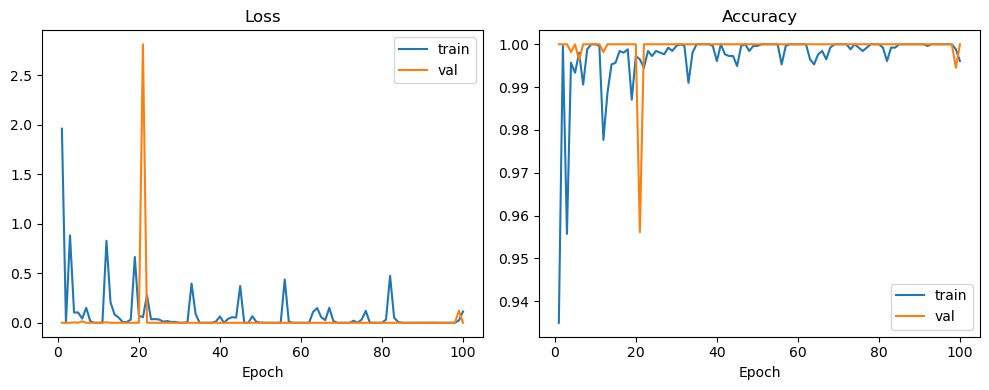

In [23]:
# ---------------------------------------------
# Plot Train and validation loss and accuracy
# ---------------------------------------------

epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='train')
plt.plot(epochs, history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='train')
plt.plot(epochs, history['val_acc'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png', dpi=200)
plt.show()


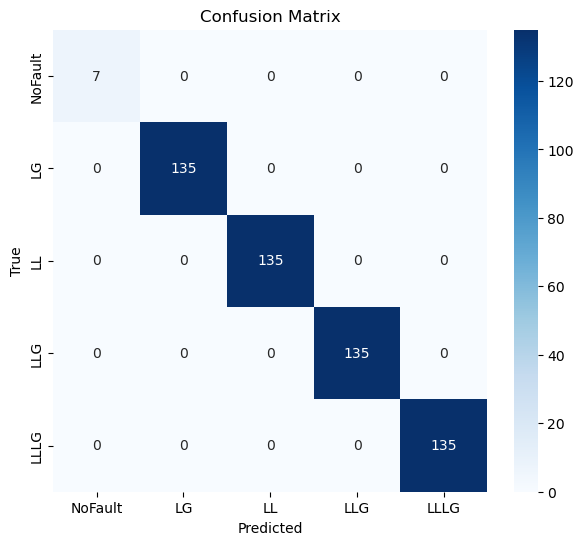

In [25]:
# -----------------------
# Plotconfusion matrix
# -----------------------

if preds.size == 0:
    print("No predictions on test set to build confusion matrix.")

cm = confusion_matrix(y_true, preds, labels=range(len(class_list)))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_list, yticklabels=class_list, cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=200)
plt.show()